In [19]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time


In [2]:
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta
from networks.loss_functions import CrossEntropy, SquareLoss
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization

from helpers.helper import *
from helpers.processing import *

from Channel.parameters import *
from Channel.transmitor import *
from Channel.modulator import *
from Channel.channel import *
from Channel.equalizer import *
from Channel.demodulator import *
from Channel.detector import *
from nnet_Generator.NNetGenerator import *

Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import glob
import os, sys
fpath ="path_Of_my_final_Big_File"
npyfilespath ="path_of_my_numpy_files"   
os.chdir(npyfilespath)
npfiles= glob.glob("*.npy")
npfiles.sort()
all_arrays = []
for i, npfile in enumerate(npfiles):
    all_arrays.append(np.load(os.path.join(npyfilespath, npfile)))
np.save(fpath, np.concatenate(all_arrays))

# Data Generation

In [3]:
# Generating the dataset
def generateDataset(nbrOfObservations, parameters, transmitor, modulator, equalizer, nnetGen, demodulator, detector, isGaussian =False):

    X = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)
    y = np.ndarray((nbrOfObservations, parameters.N), dtype=np.complex128)    
    bits_in = np.ndarray((nbrOfObservations, parameters.nb), dtype=np.int)
    bhat_out = np.ndarray((nbrOfObservations, parameters.nb), dtype=np.int)
    symb_in = np.ndarray((nbrOfObservations, parameters.n))
    symb_out = np.ndarray((nbrOfObservations, parameters.n))


    print("[INFO] Generating the dataset...")

    for i in tqdm(range(nbrOfObservations)):
        
        # Constellation
        constellation = transmitor.build_constellations(parameters.M)
        
        #source
        source = transmitor.source(parameters.nb , parameters.p) # USE IT FOR NEXT PART OF BITS
        
        # Bits to Symboles - symbol sequence
        bitsToSymbols = transmitor.bit_to_symb(source, parameters.M)

        # symbol sequence, we create a list of values of the complex symbols to use them in modulation
        s = transmitor.bit_to_symb(source, parameters.M)
        
        # channel - we take gaussian input
        if isGaussian:
            q0t = parameters.A*np.exp(-parameters.t**2) 

        else :
            q0t = modulator.mod(parameters.t,s, parameters.B)  
        
        # Neural Net Generator
        y_gen = nnetGen.nnet_gen(q0t)
        # equalized y_gen
        qzte, qzfe = equalizer.equalize(parameters.t, y_gen, parameters.z) # equalized output
        qzte = qzte.reshape(1,-1)
        # demodulation
        shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

        # detection
        stilde, indexes = detector.detector(shat, parameters.M)
        bhat = detector.symbols_to_bit(indexes, parameters.M)
        
        # SOURCE IS THE SEQUENCE OF BITS TO BE LEARNED
        
        # Modulated signal
        X[i] = np.squeeze(q0t)
        # Neural Net Generator
        y[i] = y_gen
        # original bit sequence (source)
        bits_in[i] = source
        # estimated bit sequence
        bhat_out[i] = bhat
        # original symbol sequence (source)

        symb_in[i] = np.squeeze(s)
        # estimated symbol sequence
        symb_out[i] = np.squeeze(stilde)
        
    print("[INFO] The dataset is ready now !")

    return X, y, bits_in, bhat_out, symb_in, symb_out

In [4]:
def generate_dataset_multiple_power_symbols(nbrOfObservations, nsymbols_arr, M_arr, power_arr, isGaussian=False):
       
    # bandwidth
    bandwidth = 1
    # Sample size
    Nt = 2**10
    # Number of Layers of the Generative network
    nLayers = 500
    
    for power in power_arr :
        for M in M_arr :
            for nsymbols in nsymbols_arr :
                
                # Number of bits
                nb = int(nsymbols * np.log2(M)) 
                timeMesh = int( (nb/bandwidth)+ (10*2/ nb) )
                # Initialize parameters
                parameters = Parameters(bandwidth, nsymbols, M, Nt, nLayers, timeMesh)
                # Initialize the Transmitor
                transmitor = Transmitor()
                # Initialize the Transmitor
                modulator = Modulator()
                # Initialize the Channel
                channel = Channel()
                # Initialize the Equalizer
                equalizer = Equalizer()
                # Initialize the NNetGenerator
                nnetGen = NNetGenerator(parameters)
                # Initialize the Detector
                detector = Detector(transmitor)
                # Initialize the Demodulator
                demodulator = Demodulator()
                
                X, y, bits_in, bhat_out, symb_in, symb_out = generateDataset(nbrOfObservations, parameters, transmitor, modulator, equalizer, nnetGen, demodulator, detector, isGaussian)
                
                # saving the dataset
                file_saved_name = "../data/new/data_power_"+str(power)+"_nsymbols_"+str(nsymbols)+"_M_"+str(M)+".npz"
                np.savez_compressed(file_saved_name, X=X, y=y, bits_in=bits_in, bhat_out=bhat_out, symb_in=symb_in, symb_out=symb_out)

                print("[INFO] Saved generated data for power = ", power, " , nsymbols = ",nsymbols , " , M = ",M)

In [6]:
# Number of symbols
nsymbols_arr = [1, 16]
# size of the constellation
M_arr = [8,16,32,64]
# powers
power_arr = [6e-2, 5e-2, 4e-2, 2e-2]
# nbrOfObservations
nbrOfObservations = 5000
generate_dataset_multiple_power_symbols(nbrOfObservations, nsymbols_arr, M_arr, power_arr)

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]C:\Python36\lib\site-packages\ipykernel_launcher.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Python36\lib\site-packages\ipykernel_launcher.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  0%|                                                                                 | 1/5000 [00:00<14:34,  5.71it/s]

[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:16<00:00,  6.28it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  1  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [30:58<00:00,  2.69it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:34,  6.62it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  16  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:55<00:00,  6.99it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  1  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:43<00:00,  2.80it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:39,  6.58it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  16  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:01<00:00,  6.93it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  1  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:10<00:00,  2.86it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:44,  6.54it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  16  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:25<00:00,  6.71it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  1  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:19<00:00,  2.84it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:39,  6.58it/s]

[INFO] Saved generated data for power =  0.06  , nsymbols =  16  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:40<00:00,  7.14it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  1  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [28:58<00:00,  2.88it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:39,  6.58it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  16  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:47<00:00,  7.07it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  1  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:31<00:00,  2.82it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:20,  6.76it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  16  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:04<00:00,  6.90it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  1  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:01<00:00,  2.87it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:30,  6.67it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  16  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:30<00:00,  6.66it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  1  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:23<00:00,  2.83it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<11:44,  7.09it/s]

[INFO] Saved generated data for power =  0.05  , nsymbols =  16  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:43<00:00,  7.10it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  1  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [28:54<00:00,  2.88it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<11:29,  7.25it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  16  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:35<00:00,  7.19it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  1  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [28:58<00:00,  2.88it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<11:55,  6.99it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  16  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:09<00:00,  6.86it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  1  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:01<00:00,  2.87it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<13:10,  6.33it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  16  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:37<00:00,  6.60it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  1  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:28<00:00,  2.83it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:24,  6.71it/s]

[INFO] Saved generated data for power =  0.04  , nsymbols =  16  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:40<00:00,  7.14it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  1  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [28:46<00:00,  2.90it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:00,  6.94it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  16  , M =  8
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [11:52<00:00,  7.02it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  1  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:02<00:00,  2.87it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:54,  6.45it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  16  , M =  16
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:15<00:00,  6.80it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  1  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [28:58<00:00,  2.88it/s]


[INFO] The dataset is ready now !


  0%|                                                                                 | 1/5000 [00:00<12:34,  6.62it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  16  , M =  32
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:18<00:00,  6.77it/s]


[INFO] The dataset is ready now !


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

[INFO] Saved generated data for power =  0.02  , nsymbols =  1  , M =  64
[INFO] Generating the dataset...


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [29:12<00:00,  2.85it/s]


[INFO] The dataset is ready now !
[INFO] Saved generated data for power =  0.02  , nsymbols =  16  , M =  64


# An example of the generated data

In [15]:
d1 = np.load('../data/new/data_power_0.06_nsymbols_16_M_64.npz')

In [16]:
X, y, bits_in, bhat_out, symb_in, symb_out = d1['X'], d1['y'], d1['bits_in'], d1['bhat_out'], d1['symb_in'],d1['symb_out']

C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Python36\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


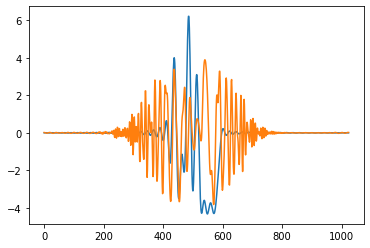

In [17]:
plt.plot(X[0])
plt.plot(y[0])

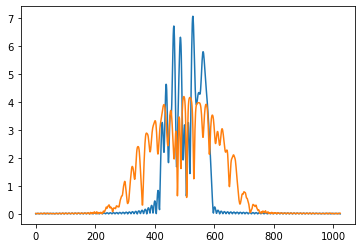

In [18]:
plt.plot(np.abs(X[0]))
plt.plot(np.abs(y[0]))

# Save all files

we cannot mix all data since they don't have all the same dimensions which will results on errors. That's why we split them by shapes.

In [108]:
# Load the 32 files
data_1 = np.load('data_power_0.04_nsymbols_1_M_8.npz')
data_2 = np.load('data_power_0.02_nsymbols_1_M_8.npz')
data_3 = np.load('data_power_0.05_nsymbols_1_M_8.npz')
data_4 = np.load('data_power_0.06_nsymbols_1_M_8.npz')

data_5 = np.load('data_power_0.02_nsymbols_1_M_16.npz')
data_7 = np.load('data_power_0.04_nsymbols_1_M_16.npz')
data_8 = np.load('data_power_0.06_nsymbols_1_M_16.npz')
data_9 = np.load('data_power_0.05_nsymbols_1_M_16.npz')

data_6 = np.load('data_power_0.05_nsymbols_1_M_32.npz')
data_10 = np.load('data_power_0.04_nsymbols_1_M_32.npz')
data_11 = np.load('data_power_0.06_nsymbols_1_M_32.npz')
data_12 = np.load('data_power_0.02_nsymbols_1_M_32.npz')

data_13 = np.load('data_power_0.02_nsymbols_1_M_64.npz')
data_14 = np.load('data_power_0.05_nsymbols_1_M_64.npz')
data_15 = np.load('data_power_0.06_nsymbols_1_M_64.npz')
data_16 = np.load('data_power_0.04_nsymbols_1_M_64.npz')

data_17 = np.load('data_power_0.02_nsymbols_16_M_8.npz')
data_18 = np.load('data_power_0.04_nsymbols_16_M_8.npz')
data_19 = np.load('data_power_0.05_nsymbols_16_M_8.npz')
data_20 = np.load('data_power_0.06_nsymbols_16_M_8.npz')

data_21 = np.load('data_power_0.06_nsymbols_16_M_32.npz')
data_22 = np.load('data_power_0.02_nsymbols_16_M_32.npz')
data_23 = np.load('data_power_0.04_nsymbols_16_M_32.npz')
data_24 = np.load('data_power_0.05_nsymbols_16_M_32.npz')

data_25 = np.load('data_power_0.06_nsymbols_16_M_16.npz')
data_26 = np.load('data_power_0.04_nsymbols_16_M_16.npz')
data_27 = np.load('data_power_0.05_nsymbols_16_M_16.npz')
data_28 = np.load('data_power_0.02_nsymbols_16_M_16.npz')

data_29 = np.load('data_power_0.04_nsymbols_16_M_64.npz')
data_30 = np.load('data_power_0.05_nsymbols_16_M_64.npz')
data_31 = np.load('data_power_0.06_nsymbols_16_M_64.npz')
data_32 = np.load('data_power_0.02_nsymbols_16_M_64.npz')

### Modulation data

In [ ]:
X = np.concatenate([data_1['X'], data_2['X'], data_3['X'], data_4['X'], data_5['X'], 
                          data_6['X'], data_7['X'], data_8['X'], data_9['X'], data_10['X'], 
                          data_11['X'], data_12['X'], data_13['X'], data_14['X'], data_15['X'],
                          data_16['X'], data_17['X'], data_18['X'], data_19['X'], data_20['X'], 
                          data_21['X'], data_22['X'], data_23['X'], data_24['X'], data_25['X'], 
                          data_26['X'], data_27['X'], data_28['X'], data_29['X'], data_30['X'],
                          data_31['X'], data_32['X']])

y = np.concatenate([data_1['y'], data_2['y'], data_3['y'], data_4['y'], data_5['y'], 
                          data_6['y'], data_7['y'], data_8['y'], data_9['y'], data_10['y'], 
                          data_11['y'], data_12['y'], data_13['y'], data_14['y'], data_15['y'],
                          data_16['y'], data_17['y'], data_18['y'], data_19['y'], data_20['y'], 
                          data_21['y'], data_22['y'], data_23['y'], data_24['y'], data_25['y'], 
                          data_26['y'], data_27['y'], data_28['y'], data_29['y'], data_30['y'],
                          data_31['y'], data_32['y']])

In [107]:
# Save the new npz file
np.savez_compressed('160K_XY.npz', X=X, y=y )

#### Data of only 16 symbols, these are easier to learn by the network

In [113]:
import gc
gc.collect()

8

In [114]:
X_ = np.concatenate([data_17['X'], data_18['X'], data_19['X'], data_20['X'], 
                          data_21['X'], data_22['X'], data_23['X'], data_24['X'], data_25['X'], 
                          data_26['X'], data_27['X'], data_28['X'], data_29['X'], data_30['X'],
                          data_31['X'], data_32['X']])

y_ = np.concatenate([data_17['y'], data_18['y'], data_19['y'], data_20['y'], 
                          data_21['y'], data_22['y'], data_23['y'], data_24['y'], data_25['y'], 
                          data_26['y'], data_27['y'], data_28['y'], data_29['y'], data_30['y'],
                          data_31['y'], data_32['y']])

In [115]:
# Save the new npz file
np.savez_compressed('80K_XY_16_symb.npz', X=X_, y=y_ )

### Bits-to-Bits data

In [88]:
bits_in_3 = np.concatenate([data_1['bits_in'], data_2['bits_in'], data_3['bits_in'], data_4['bits_in']])
bhat_out_3 = np.concatenate([data_1['bhat_out'], data_2['bhat_out'], data_3['bhat_out'], data_4['bhat_out']])

bits_in_4 = np.concatenate([data_5['bits_in'], data_7['bits_in'], data_8['bits_in'], data_9['bits_in']])
bhat_out_4 = np.concatenate([data_5['bhat_out'], data_7['bhat_out'], data_8['bhat_out'], data_9['bhat_out']])

bits_in_5 = np.concatenate([data_6['bits_in'], data_10['bits_in'], data_11['bits_in'], data_12['bits_in']])
bhat_out_5 = np.concatenate([data_6['bhat_out'], data_10['bhat_out'], data_11['bhat_out'], data_12['bhat_out']])

bits_in_6 = np.concatenate([data_13['bits_in'], data_14['bits_in'], data_15['bits_in'], data_16['bits_in']])
bhat_out_6 = np.concatenate([data_13['bhat_out'], data_14['bhat_out'], data_15['bhat_out'], data_16['bhat_out']])

bits_in_48 = np.concatenate([data_17['bits_in'], data_18['bits_in'], data_19['bits_in'], data_20['bits_in']])
bhat_out_48 = np.concatenate([data_17['bhat_out'], data_18['bhat_out'], data_19['bhat_out'], data_20['bhat_out']])

bits_in_80 = np.concatenate([data_21['bits_in'], data_22['bits_in'], data_23['bits_in'], data_24['bits_in']])
bhat_out_80 = np.concatenate([data_21['bhat_out'], data_22['bhat_out'], data_23['bhat_out'], data_24['bhat_out']])

bits_in_64 = np.concatenate([data_25['bits_in'], data_26['bits_in'], data_27['bits_in'], data_28['bits_in']])
bhat_out_64 = np.concatenate([data_25['bhat_out'], data_26['bhat_out'], data_27['bhat_out'], data_28['bhat_out']])

bits_in_96 = np.concatenate([data_29['bits_in'], data_30['bits_in'], data_31['bits_in'], data_32['bits_in']])
bhat_out_96 = np.concatenate([data_29['bhat_out'], data_30['bhat_out'], data_31['bhat_out'], data_32['bhat_out']])

In [106]:
np.savez_compressed('20K_bits_3.npz', bits_in=bits_in_3, bhat_out=bhat_out_3)
np.savez_compressed('20K_bits_4.npz', bits_in=bits_in_4, bhat_out=bhat_out_4)
np.savez_compressed('20K_bits_5.npz', bits_in=bits_in_5, bhat_out=bhat_out_5)
np.savez_compressed('20K_bits_6.npz', bits_in=bits_in_6, bhat_out=bhat_out_6)

np.savez_compressed('20K_bits_48.npz', bits_in=bits_in_48, bhat_out=bhat_out_48)
np.savez_compressed('20K_bits_80.npz', bits_in=bits_in_80, bhat_out=bhat_out_80)
np.savez_compressed('20K_bits_64.npz', bits_in=bits_in_64, bhat_out=bhat_out_64)
np.savez_compressed('20K_bits_96.npz', bits_in=bits_in_96, bhat_out=bhat_out_96)

### Symbol-to-Symbol data

In [68]:
symb_in_1 = np.concatenate([data_1['symb_in'], data_2['symb_in'], data_3['symb_in'], data_4['symb_in'], data_5['symb_in'], 
                          data_6['symb_in'], data_7['symb_in'], data_8['symb_in'], data_9['symb_in'], data_10['symb_in'], 
                          data_11['symb_in'], data_12['symb_in'], data_13['symb_in'], data_14['symb_in'], data_15['symb_in'],
                          data_16['symb_in']])

symb_out_1 = np.concatenate([data_1['symb_out'], data_2['symb_out'], data_3['symb_out'], data_4['symb_out'], data_5['symb_out'], 
                           data_6['symb_out'], data_7['symb_out'], data_8['symb_out'], data_9['symb_out'], data_10['symb_out'],
                           data_11['symb_out'], data_12['symb_out'], data_13['symb_out'], data_14['symb_out'], 
                           data_15['symb_out'], data_16['symb_out']])

In [69]:
symb_in_16 = np.concatenate([data_17['symb_in'], data_18['symb_in'], data_19['symb_in'], data_20['symb_in'], 
                          data_21['symb_in'], data_22['symb_in'], data_23['symb_in'], data_24['symb_in'], data_25['symb_in'], 
                          data_26['symb_in'], data_27['symb_in'], data_28['symb_in'], data_29['symb_in'], data_30['symb_in'],
                          data_31['symb_in'], data_32['symb_in']])

symb_out_16 = np.concatenate([data_17['symb_out'], data_18['symb_out'], data_19['symb_out'], data_20['symb_out'],
                              data_21['symb_out'], data_22['symb_out'], 
                           data_23['symb_out'], data_24['symb_out'], data_25['symb_out'], data_26['symb_out'], 
                           data_27['symb_out'], data_28['symb_out'], data_29['symb_out'], data_30['symb_out'], 
                           data_31['symb_out'], data_32['symb_out']])

In [105]:
np.savez_compressed('80K_symb_1.npz', symb_in=symb_in_1, symb_out=symb_out_1 )
np.savez_compressed('80K_symb_16.npz', symb_in=symb_in_16, symb_out=symb_out_16 )